In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import tensorflow_io as tfio
import os
import cv2
import imghdr
import zipfile
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import importlib, pkg_resources
importlib.reload(pkg_resources)
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = "/home/artificialbrain/Documents/code/sickle-cell-demo/datasets"

In [4]:
os.listdir(os.path.join(data_dir))

['Negative', 'Positive']

In [5]:
# Negative
img = cv2.imread(os.path.join(data_dir, 'Negative/Clear/', '1.jpg' ))

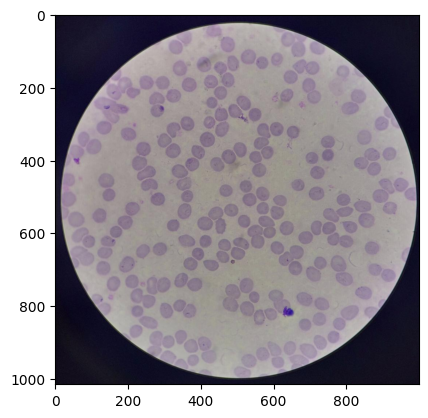

In [6]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

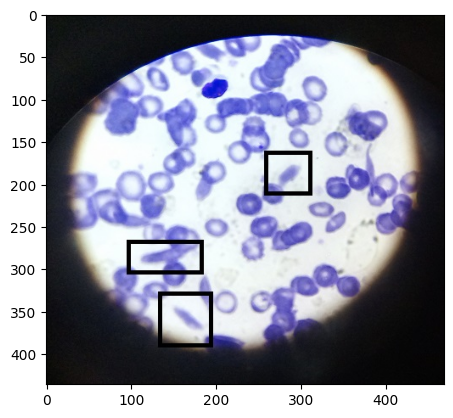

In [7]:
# Sickle cell disease
img2 = cv2.imread(os.path.join(data_dir, 'Positive/Labelled/', '36.jpg' ))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

In [8]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),  # Adjust the size as needed
    batch_size=32,  # Adjust the batch size as needed
    label_mode='int'  # 'int' for integer labels, 'categorical' for one-hot encoded labels, etc.
)

Found 991 files belonging to 2 classes.


In [9]:
from sklearn.model_selection import train_test_split
# Step 2: Convert the dataset to numpy arrays
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

images, labels = dataset_to_numpy(data)

# Step 3: Split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Step 4: Rescale the images
x_train = x_train / 255.0
x_test = x_test / 255.0

# Optional: Add a channel dimension if necessary (for grayscale images, the dimension is already there)
# x_train = x_train[..., np.newaxis]
# x_test = x_test[..., np.newaxis]

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 792
Number of original test examples: 199


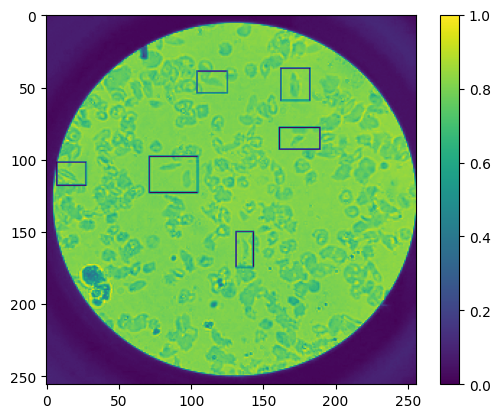

In [10]:
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

2024-06-16 20:52:02.269807: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 622854144 exceeds 10% of free system memory.


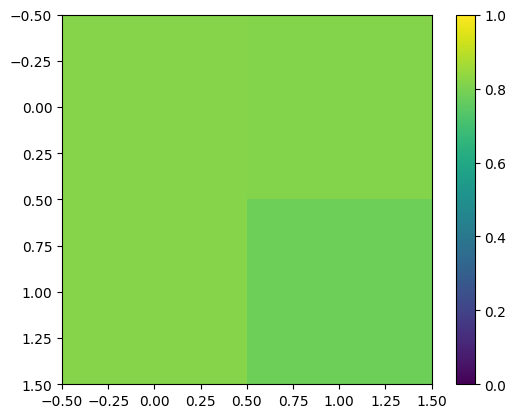

In [11]:
x_train_small = tf.image.resize(x_train, (2,2)).numpy()
x_test_small = tf.image.resize(x_test, (2,2)).numpy()

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [12]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [13]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 788
Number of unique 3s:  673
Number of unique 6s:  115
Number of unique contradicting labels (both 3 and 6):  0

Initial number of images:  792
Remaining non-contradicting unique images:  788


In [14]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

_ = remove_contradicting(x_train_bin, y_train_nocon)


Number of unique images: 24
Number of unique 3s:  19
Number of unique 6s:  1
Number of unique contradicting labels (both 3 and 6):  4

Initial number of images:  788
Remaining non-contradicting unique images:  20


In [15]:
# Quantum Code Begins

def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

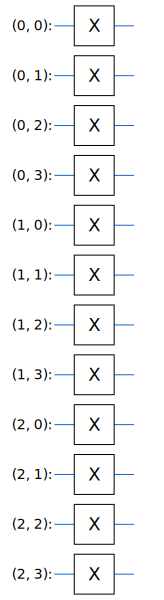

In [16]:
SVGCircuit(x_train_circ[0])

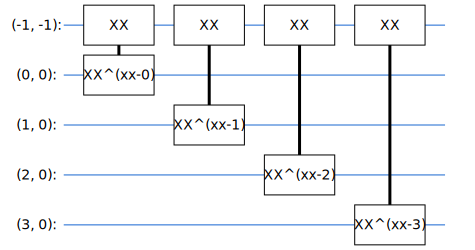

In [17]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)
            
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)


In [18]:
# Quantum Neural Model to Classify Sickle Cell and Non-Sickle Cell
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)


In [19]:
model_circuit, model_readout = create_quantum_model()
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)


Epoch 1/3
25/25 [==============================] - 17s 668ms/step - loss: 0.9882 - hinge_accuracy: 0.7245 - val_loss: 0.9731 - val_hinge_accuracy: 0.8099
Epoch 2/3
25/25 [==============================] - 19s 743ms/step - loss: 0.9549 - hinge_accuracy: 0.8263 - val_loss: 0.9387 - val_hinge_accuracy: 0.8055
Epoch 3/3
7/7 [==============================] - 1s 84ms/step - loss: 0.8654 - hinge_accuracy: 0.8055


In [22]:
#accuracy
qnn_results[1] * 100 

80.54847121238708